In [440]:
# import the necessary packages
from collections import deque
from imutils.video import VideoStream
import numpy as np
import argparse
import cv2
import imutils
from skimage.morphology import erosion, dilation, opening, closing
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
from PIL import Image
from IPython.display import Image as IPImage, display


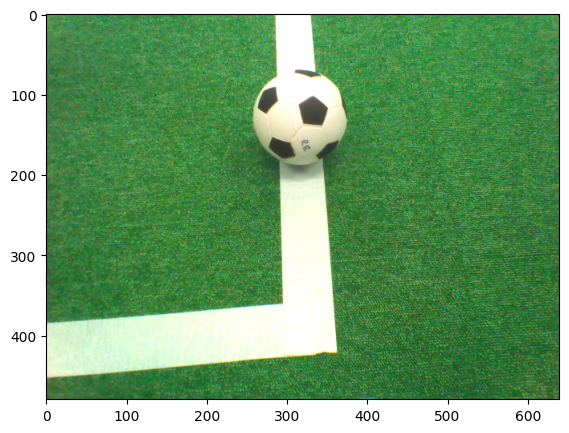

In [441]:
image_path = 'basic.png' 
frame = cv2.imread(image_path)


frame_copy =frame.copy()


#Visualize function
def visualize(image, gray = False, hsv_rep = False):
    plt.figure(figsize=(10, 5))

    if hsv_rep and not gray:
        img = cv2.cvtColor(image, cv2.COLOR_HSV2BGR)
        plt.imshow(img) 

    elif not hsv_rep and gray:
        plt.imshow(image, cmap='gray')

    else:
        plt.imshow(image) 

    plt.show()

frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
visualize(frame)

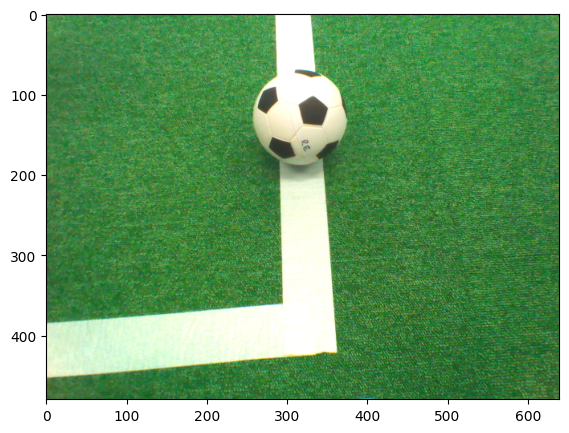

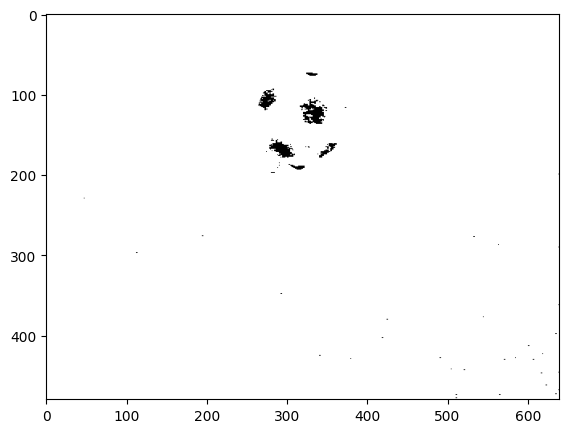

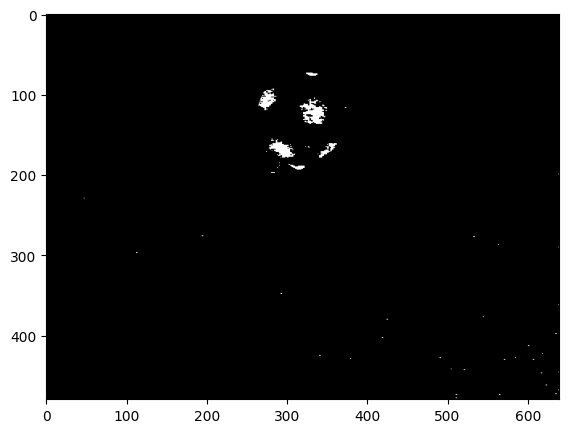

In [442]:
# To select black, white, and gray values, it chooses values with a low saturation
hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
visualize(hsv, hsv_rep=True)

# Define the threshold values
h_threshold = 100  # param
s_threshold = 65    # param
v_threshold = 110   # param

# Create masks for each channel
h_mask = hsv[:, :, 0] < h_threshold
s_mask = hsv[:, :, 1] < s_threshold
v_mask = hsv[:, :, 2] < v_threshold

# Combine masks using logical AND operations
combined_mask = v_mask & s_mask & h_mask

# Create the final mask
mask_inv = np.ones_like(combined_mask, dtype=np.uint8) * 255
mask_inv[combined_mask] = 0

visualize(mask_inv, gray=True)
mask = cv2.bitwise_not(mask_inv)
visualize(mask, gray=True)


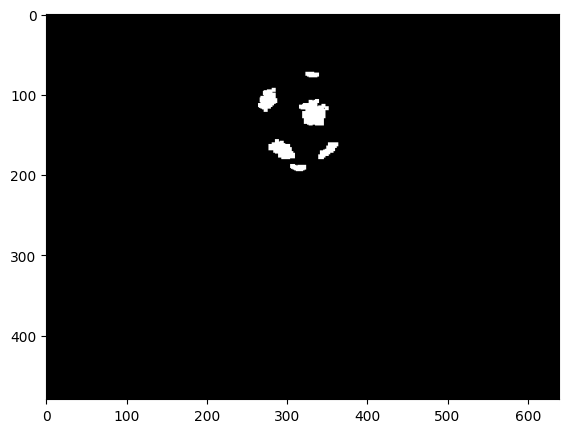

In [443]:
#This is what the dude did
iterat_erode = 1 #param
k_erode = 2 #param
kernel_erode = np.ones((k_erode, k_erode), np.uint8)

iterat_dilate = 1 #param
k_dilate = 5 #param
kernel_dilate = np.ones((k_dilate, k_dilate), np.uint8)

mask1 = cv2.erode(mask, kernel_erode, iterat_erode) 
mask2 = cv2.dilate(mask1, kernel_dilate, iterat_dilate) 

visualize(mask2, gray = True)

# Find coordinates of positive pixels
area_limit = 25 #param

positive_pixels = np.column_stack(np.where(mask2 > 0))
contours = cv2.findContours(mask2.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(contours)
filtered_contours = [contour for contour in contours if cv2.contourArea(contour) > area_limit]


if len(filtered_contours) > 0:
    # Extract positive pixels from filtered contours
    positive_pixels_contour = np.column_stack(np.where(cv2.drawContours(np.zeros_like(mask2), [contour], -1, (255, 255, 255), thickness=cv2.FILLED) > 0))
    frame[positive_pixels[:, 0], positive_pixels[:, 1]] = [0, 0, 255]
    centerT = np.mean(positive_pixels, axis=0).astype(int)
    center = [centerT[1], centerT[0]]

    distances = np.linalg.norm(positive_pixels - centerT, axis=1)
    radius = np.max(distances)

    cv2.circle(frame, tuple(map(int, center)), int(radius), (0, 255, 255), 2)
    cv2.circle(frame, tuple(map(int, center)), 5, (255, 0, 0), -1)

visualize(frame)

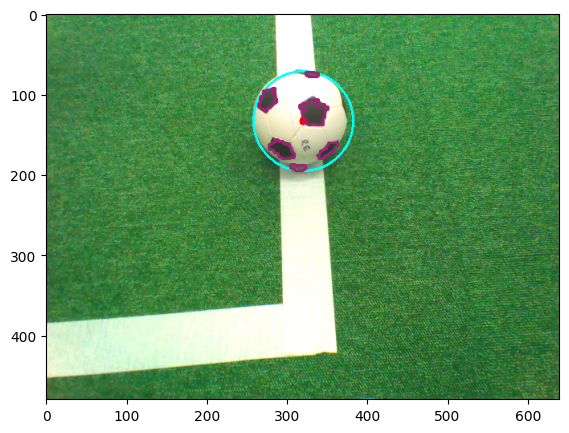

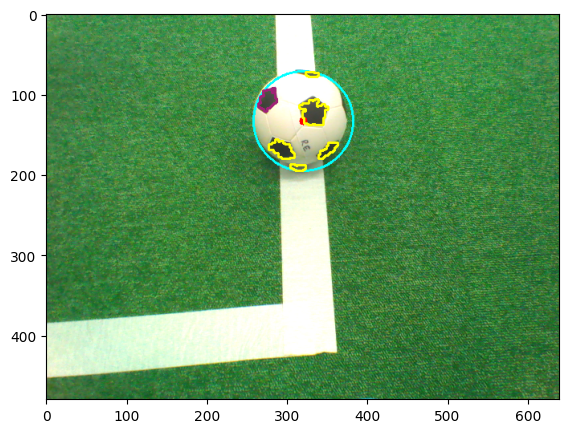

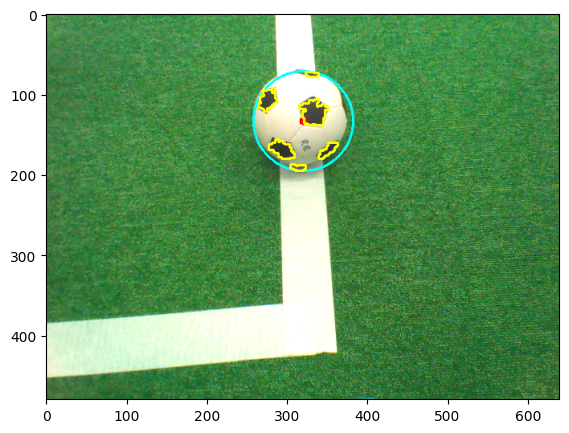

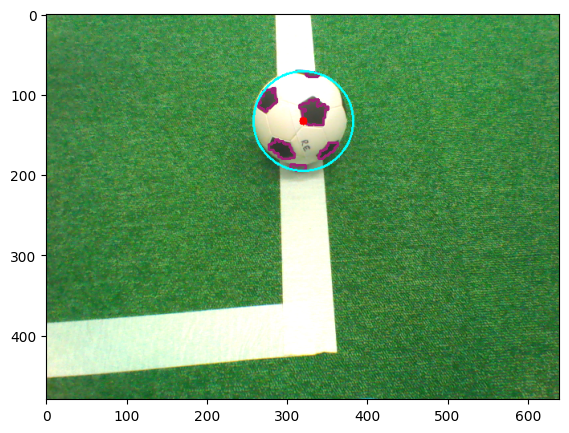

320 133


In [446]:
# Find contours
contours, _ = cv2.findContours(mask2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


for c in contours:
    cv2.drawContours(frame, [c], -1, (160, 34, 119), 2)

visualize(frame)
#Begin of group algorithm
ratio_limit = 1.4 #param

distances = 999* np.ones((len(contours), len(contours)))

for i in range(len(contours)):
    for j in range(i + 1, len(contours)):
        # Find the centroid of each contour
        M1 = cv2.moments(contours[i])
        centroid1 = (int(M1['m10'] / M1['m00']), int(M1['m01'] / M1['m00']))

        M2 = cv2.moments(contours[j])
        centroid2 = (int(M2['m10'] / M2['m00']), int(M2['m01'] / M2['m00']))

        # Calculate Euclidean distance between centroids
        distance = np.sqrt((centroid1[0] - centroid2[0])**2 + (centroid1[1] - centroid2[1])**2)
        distances[i][j] = distance
        distances[j][i] = distance

groups = []

min_distances_indices = np.min(distances, axis=1)
sourted_indices = np.argsort(min_distances_indices)


for i in sourted_indices:
    if not (any(i in sublist for sublist in groups)): #checks if that contour hasn't appear yet and calculate its own group
        group = []
        sorted_indices = np.argsort(distances[i])

        max_distance = distances[i, sorted_indices[1]] #Used to compare. The biggest one of the two closest

        group.extend(sorted_indices[:2].tolist())

        for other_index in sorted_indices[2:]:
            for current_index in group:
                if (distances[current_index, other_index] < ratio_limit * max_distance) and (other_index not in group):
                    group.append(other_index)

        groups.append(group)

white_threshold = 200  #param
white_pixel_ratio_threshold = 0.2 #param
old_best_ratio = 0

for group in groups:
    group_contours = [contours[i] for i in group]

    
    frame_copy =frame.copy()
    
    for c in group_contours:
        cv2.drawContours(frame_copy, [c], -1, (255, 255, 0), 2)

    visualize(frame_copy)

    # Concatenate all contours in the group
    group_contour = np.concatenate(group_contours)

    # Calculate minimum enclosing circle
    (x, y), radius = cv2.minEnclosingCircle(group_contour)
    center = (int(x), int(y))
    radius = int(radius)

    # Create a mask for the area encompassed by the circle
    mask_circle = np.zeros_like(frame, dtype=np.uint8)
    cv2.circle(mask_circle, center, radius, (255, 255, 255), thickness=-1)

    # Convert the mask to binary (0 or 255)
    mask_binary = cv2.cvtColor(mask_circle, cv2.COLOR_BGR2GRAY)

    # Calculate the ratio of white pixels in the circle area
    white_pixel_ratio = np.sum(frame[:, :, 2][mask_binary == 255] > white_threshold) / np.sum(mask_binary == 255)


    # Draw the circle only if the white pixel ratio is above the threshold
    if white_pixel_ratio > white_pixel_ratio_threshold and white_pixel_ratio > old_best_ratio:
        old_best_ratio = white_pixel_ratio
        best_radius = radius
        best_center = center

cv2.circle(frame, best_center, best_radius, (0, 255, 255), 2)
cv2.circle(frame, best_center, 5, (255, 0, 0), -1)
visualize(frame)
x, y = best_center
print(x,y)